In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.version
sys.version_info

'3.7.0 (default, Jun 28 2018, 13:15:42) \n[GCC 7.2.0]'

sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)

In [3]:
#export
from nb_001b import *
import sys, PIL, matplotlib.pyplot as plt, itertools, math, random, collections, torch
import scipy.stats, scipy.special

from enum import Enum, IntEnum
from torch import tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from operator import itemgetter, attrgetter
from numpy import cos, sin, tan, tanh, log, exp

from functools import reduce
from collections import defaultdict, abc, namedtuple, Iterable
from PIL import Image

# CIFAR subset data

First we want to view our data to check if everything is how we expect it to be.

## Setup

In [5]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

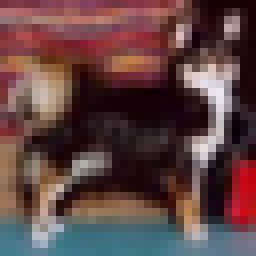

In [6]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = Image.open(dog_fn)
dog_image.resize((256,256))

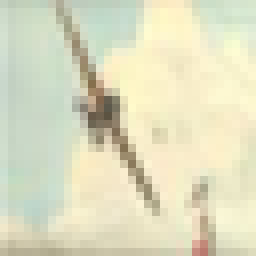

In [7]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

We will build a Dataset class for our image files. A Dataset class needs to have two functions: length and get-item. Our FilesDataset additionally gets the image files from their respective directories and transforms them to tensors.

In [8]:
list((TRAIN_PATH).iterdir())
list((TRAIN_PATH).iterdir())[0].is_dir()

[PosixPath('data/cifar10_dog_air/train/dog'),
 PosixPath('data/cifar10_dog_air/train/airplane')]

True

In [10]:
#export
def find_classes(folder):
    # return class list
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    assert(len(classes)>0)
    return sorted(classes, key=lambda d: d.name)

def get_image_files(c):
    # get all image file name from class
    return [o for o in c.iterdir()
            if not o.name.startswith('.') and not o.is_dir()]

def pil2tensor(image):
    arr = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1) # height x width x channels
    arr = arr.permute(2,0,1) # channels x height x width
    return arr.float().div_(255) # normalize between 0 and 1

In [11]:
#export
class FilesDataset(Dataset):
    def __init__(self, folder, classes=None):
        # var: X:filenames,y:class (number), class (name)
        self.fns, self.y = [], []
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [12]:
train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test')

In [13]:
train_ds.classes

['airplane', 'dog']

In [23]:
x = PIL.Image.open(train_ds.fns[0]).convert('RGB')

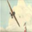

PIL.Image.Image

(32, 32)

convert to bytes -> tensor


3072

In [24]:
x
type(x)
x.size

print('convert to bytes -> tensor')

temp=torch.ByteStorage(x.tobytes())
temp.size()
temp2=torch.ByteTensor(temp).view(x.size[1],x.size[0],-1)

In [25]:
temp2.size()

torch.Size([32, 32, 3])

In [14]:
train_ds.fns[:5]
train_ds.y[:5]

[PosixPath('data/cifar10_dog_air/train/airplane/5665_airplane.png'),
 PosixPath('data/cifar10_dog_air/train/airplane/42446_airplane.png'),
 PosixPath('data/cifar10_dog_air/train/airplane/43184_airplane.png'),
 PosixPath('data/cifar10_dog_air/train/airplane/7930_airplane.png'),
 PosixPath('data/cifar10_dog_air/train/airplane/30257_airplane.png')]

[0, 0, 0, 0, 0]

In [15]:
train_ds[0][0].size()

torch.Size([3, 32, 32])

In [16]:
len(train_ds), len(valid_ds)

(10000, 2000)

In [17]:
#export
def image2np(image): 
    # convert float tensor (between 0 and 1) back to normal picture (0 to 255, height x width x channels)
    return image.cpu().permute(1,2,0).numpy()

In [37]:
x,y = train_ds[0]
x.type()
x.size()
x

'torch.FloatTensor'

torch.Size([3, 32, 32])

tensor([[[0.7686, 0.7412, 0.7569,  ..., 0.8353, 0.8353, 0.8431],
         [0.8039, 0.7804, 0.7922,  ..., 0.8510, 0.8431, 0.8510],
         [0.8118, 0.7843, 0.8000,  ..., 0.8314, 0.8275, 0.8314],
         ...,
         [0.8980, 0.8588, 0.8627,  ..., 0.9255, 0.9216, 0.9255],
         [0.8235, 0.7725, 0.8078,  ..., 0.8941, 0.9059, 0.9176],
         [0.7490, 0.7059, 0.7176,  ..., 0.8157, 0.8314, 0.8667]],

        [[0.8196, 0.7922, 0.8118,  ..., 0.8941, 0.8941, 0.9020],
         [0.8549, 0.8314, 0.8471,  ..., 0.9176, 0.9137, 0.9137],
         [0.8627, 0.8353, 0.8510,  ..., 0.8980, 0.8941, 0.8902],
         ...,
         [0.8706, 0.8275, 0.8353,  ..., 0.9294, 0.9255, 0.9216],
         [0.7961, 0.7451, 0.7804,  ..., 0.8941, 0.9059, 0.9137],
         [0.7216, 0.6784, 0.6902,  ..., 0.8118, 0.8275, 0.8588]],

        [[0.7529, 0.7216, 0.7294,  ..., 0.8118, 0.8039, 0.8039],
         [0.7882, 0.7608, 0.7608,  ..., 0.8275, 0.8235, 0.8235],
         [0.7961, 0.7647, 0.7686,  ..., 0.7961, 0.8078, 0.

airplane


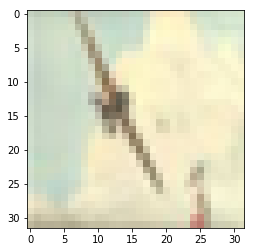

In [19]:
plt.imshow(image2np(x))
print(train_ds.classes[y])

In [20]:
bs=64

In [26]:
??DataBunch

In [27]:
data = DataBunch(train_ds, valid_ds, bs=bs) # no transformation yet
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [32]:
#export
def show_image(img, ax=None, figsize=(3,3), hide_axis=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img))
    if hide_axis: ax.axis('off')

def show_image_batch(dl, classes, rows=None, figsize=(12,15)):
    # show row x row image matrix with class label
    x,y = next(iter(dl))
    if rows is None: rows = int(math.sqrt(len(x)))
    show_images(x[:rows*rows],y[:rows*rows],rows, classes)

def show_images(x,y,rows, classes, figsize=(9,9)):
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

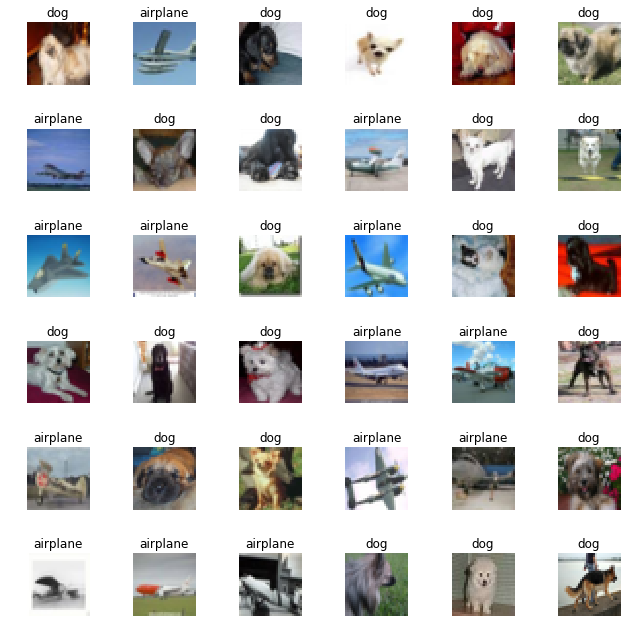

In [22]:
show_image_batch(data.train_dl, train_ds.classes, rows=6)

# Data augmentation

Now we are going augment our data to increase our training set. We will start by changing the brightness and contrast of our images.

Brightness is computed by taking the logit of the change and adding it to the logit of the images pixels. Finally we take the sigmoid of the result.

Contrast is computed by simply multiplying pixel values by the scale.

## Lighting

We will start by changing the brightness and contrast of our images.

## Method
### Brightness

Brightness refers to where does our image stand on the dark-light spectrum. Brightness is applied by adding a positive constant to each of the image's channels. This works because each of the channels in an image goes from 0 (darkest) to 255 (brightest) in a dark-light continum. (0, 0, 0) is black (total abscence of light) and (255, 255, 255) is white (pure light). You can check how this works by experimenting by yourself here.

Parameters

Change How much brightness do we want to add to (or take from) the image.

$C \in \mathbb{R}$

### Contrast

Contrast refers to how sharp a distinction there is between birghter and darker sections of our image. To increase contrast we need darker pixels to be darker and lighter pixels to be lighter. In other words, we would like channels with a value smaller than 128 to decrease and channels with a value of greater than 128 to increase.

Parameters

Scale How much contrast do we want to add to (or remove from) the image.

$C \in [0, inf]$

### On logit and sigmoid

Notice that for both transformations we first apply the logit to our tensor (convert x: 0 to 1 to x: -inf to inf), then apply the transformation (add constant to x for brightness or multiply constant to xfor contrast) and finally take the sigmoid (back to x: 0 and 1). This is important for two reasons.

First, we don't want to overflow our tensor values. In other words, we need our final tensor values to be $T_{ij} \in [0,1]$. Imagine, for instance, a tensor value at 0.99. We want to increase its brightness, but we can’t go over 1.0. By doing logit first, which first moves our space to $-inf$ to $+inf$, this works fine. The same applies to contrast if we have a scale S >1 (might make some of our tensor values greater than one).

Second, when we apply contrast, we need to affect the dispersion (state of being spread over an area) of values around the middle value. Say we want to increase contrast. Then we need the bright values (>0.5) to get brighter and dark values (<0.5) to get darker. We must first transform our tensor values so our values which were originally <0.5 are now negative and our values which were originally >0.5 are positive. This way, when we multiply by a constant, the dispersion around 0 will increase (small numbers around 0 * positive scale = small numbers => they don't change much?). The logit function does exactly this and allows us to increase or decrease dispersion around a mid value.

In [35]:
??partial

# return a new function with fewer parameters and fixed values set for the original function

In [36]:
def multiply(x,y,z):
        return 3*x + 2*y + z
func1 = partial(multiply,3)
print(func1(2,1))

func2 = partial(multiply,3,2)
print(func2(1))

14
14


In [47]:
#export
# def logit(x):  return -(1/x-1).log()
def logit_(x): return (x.reciprocal_().sub_(1)).log_().neg_() # -log(1/x -1)

def brightness(x, change): 
    # the change to be added to x for brightness should be between 0 and 1, as it will be transformed using logit
    # so that they on the same scale when adding?
    return x.add_(scipy.special.logit(change))
def contrast(x, scale): return x.mul_(scale)

def _apply_lighting(x, func):
    if func is None: return x
    return func(logit_(x)).sigmoid()

def apply_lighting(func): 
    # a function which accept only a function input and return a partial function (which accept that function input)
    return partial(_apply_lighting, func=func)

In [39]:
def apply_contrast(scale): return apply_lighting(partial(contrast, scale=scale))

In [55]:
x = lambda: train_ds[1][0]

# Don't use the following to test these transformation functions
# as these functions above are meant to be used to permanently transform tensor
# x = train_ds[1][0]. 

In [51]:
x.size()
x.type()

torch.Size([3, 32, 32])

'torch.FloatTensor'

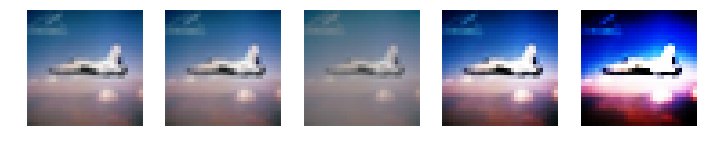

In [56]:
_,axes = plt.subplots(1,5, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_contrast(1.0)(x()), axes[1])
show_image(apply_contrast(0.5)(x()), axes[2])
show_image(apply_contrast(2.0)(x()), axes[3])
show_image(apply_contrast(5.0)(x()), axes[4])

In [57]:
def apply_brightness(change):
    return apply_lighting(partial(brightness, change=change))

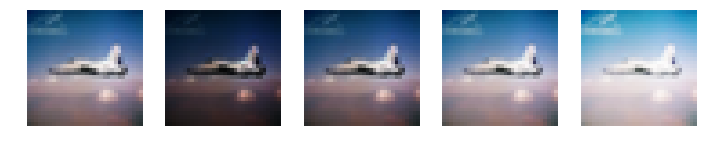

In [58]:
_,axes = plt.subplots(1,5, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_brightness(0.2)(x()), axes[1])
show_image(apply_brightness(0.4)(x()), axes[2])
show_image(apply_brightness(0.6)(x()), axes[3])
show_image(apply_brightness(0.8)(x()), axes[4])

In [69]:
#export
# TODO:what is this
def listify(p=None, q=None):
    if p is None: p=[]
    elif not isinstance(p, Iterable): p=[p]
    n = q if type(q)==int else 1 if q is None else len(q)
    if len(p)==1: p = p * n
    return p

def compose(funcs):
    # funcs is list of partial functions. Execute this list of functions in order
    # compose acts as a wrapper for multiple PARTIAL functions in funcs list
    def _inner(x, *args, **kwargs):
        for f in funcs: x = f(x, *args, **kwargs)
        return x
    return _inner if funcs else None

In [65]:
sc = 0.5
cb = 0.5
compose([partial(contrast, scale=0.5),partial(brightness, change=0.5)])

<function __main__.compose.<locals>._inner(x, *args, **kwargs)>

```
def apply_lighting(func): 
    # a function which accept only a function input and return a partial function (which accept that function input)
    return partial(_apply_lighting, func=func)
    
def _apply_lighting(x, func):
    if func is None: return x
    
    # this is where compose will kick in. I.e of the actual call
    # _apply_lighting(x, compose) # partial
    # -> compose(logit_(x))
    # -> _inner(logit_(x), args and kwargs)
    # -> x = contrast(logit_(x),scale_contrast)
    # -> x = brightness(x,change_brightness)
    # -> return x.sigmoid()
    return func(logit_(x)).sigmoid() 
```

In [70]:
def apply_brightness_contrast(scale_contrast, change_brightness):
    # remember that apply_lighting return a partial function with func input
    combined_func = compose([partial(contrast, scale=scale_contrast),
                               partial(brightness, change=change_brightness)]
                             )
    return apply_lighting(combined_func)

In [93]:
# explaining compose function
def show_stuff(x,k1=42,k2='yolo'):
    print(x)
    print(k1)
    print(k2)
def wrap(func): # passing in a partial function
    def inner(*args,**kwargs): # since func remember its fixed parameter, 
        #its wrapper, inner, will also get these fixed parameters
        func(*args,**kwargs)        
    return inner

func3 = partial(show_stuff,k2='YOLO BIATCH') # func3 already remember its fixed parameter here
wrap(func3)(3)

3
42
YOLO BIATCH


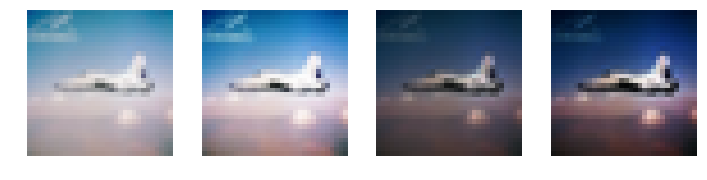

In [71]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(apply_brightness_contrast(0.75, 0.7)(x()), axes[0]) # less contrast,  brighter
show_image(apply_brightness_contrast(1.3,  0.7)(x()), axes[1]) # more contrast, brighter
show_image(apply_brightness_contrast(0.75, 0.3)(x()), axes[2]) # less contrast, dimmer
show_image(apply_brightness_contrast(1.3,  0.3)(x()), axes[3]) # more contrast, dimmer



## Random lighting

Next, we will make our previous transforms random since we are interested in automatizing the transforms pipeline. We will achieve this by making our parameters stochastic with a specific distribution: uniform for brightness and log_uniform for contrast. **TODO WHY**

In [ ]:
#export
def uniform(low, high, size=None):
    return random.uniform(low,high) if size is None else torch.FloatTensor(size).uniform_(low,high)

def log_uniform(low, high, size=None):
    res = uniform(log(low), log(high), size)
    return exp(res) if size is None else res.exp_()

def rand_bool(p, size=None): return uniform(0,1,size)<p

TfmType = IntEnum('TfmType', 'Start Affine Coord Pixel Lighting')

def brightness(x, change: uniform) -> TfmType.Lighting:
    return x.add_(scipy.special.logit(change))

def contrast(x, scale: log_uniform) -> TfmType.Lighting:
    return x.mul_(scale)

In [ ]:
scipy.stats.gmean([log_uniform(0.5,2.0) for _ in range(1000)])

In [ ]:
#export
import inspect

def get_default_args(func):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

def resolve_args(func, **kwargs):
    kwargs.pop('p', None)
    def_args = get_default_args(func)
    for k,v in func.__annotations__.items():
        if k == 'return': continue
        if not k in kwargs and k in def_args:
            kwargs[k] = def_args[k]
        else:
            arg = listify(kwargs.get(k, 1))
            kwargs[k] = v(*arg)
    return kwargs

def noop(x=None, *args, **kwargs): return x

class Transform():
    def __init__(self, func, **kwargs):
        self.func,self.kw = func,kwargs
        self.tfm_type = self.func.__annotations__['return']
        
    def __repr__(self):
        return f'{self.func.__name__}_tfm->{self.tfm_type.name}; {self.kw}'
    
    def __call__(self):
        if 'p' in self.kw and not rand_bool(self.kw['p']): return noop
        kwargs = resolve_args(self.func, **self.kw)
        return partial(self.func, **kwargs)

In [ ]:
resolve_args(brightness, change=(0.25,0.75),)

In [ ]:
contrast_tfm = partial(Transform, contrast)
tfm = contrast_tfm(scale=(0.3,3))
tfm

In [ ]:
# all the same
tfm = tfm()

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_lighting(tfm)(x()), ax)

In [ ]:
tfm = contrast_tfm(scale=(0.3,3), p=0.5)

# different
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_lighting(tfm())(x()), ax)

## Decorator and composition

**Continue from here**

In [ ]:
#export
def reg_partial(cl, func):
    setattr(sys.modules[func.__module__], f'{func.__name__}_tfm', partial(cl,func))
    return func

def reg_transform(func): return reg_partial(Transform, func)

def resolve_tfms(tfms): return [f() for f in listify(tfms)]

@reg_transform
def brightness(x, change: uniform) -> TfmType.Lighting:  return x.add_(scipy.special.logit(change))

@reg_transform
def contrast(x, scale: log_uniform) -> TfmType.Lighting: return x.mul_(scale)

In [ ]:
def apply_tfms(tfms):
    func = apply_lighting(compose(resolve_tfms(tfms)))
    return lambda x: func(x.clone())

In [ ]:
x = train_ds[1][0]

In [ ]:
tfms = [contrast_tfm(scale=(0.3,3.0), p=0.5),
        brightness_tfm(change=(0.35,0.65), p=0.5)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)

In [ ]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    tfm = apply_tfms(tfms)
    show_image(tfm(x), axes[0][i])
    show_image(tfm(x), axes[1][i])

# Affine

## Deterministic affine

In [ ]:
#export
def grid_sample_nearest(input, coords, padding_mode='zeros'):
    if padding_mode=='border': coords.clamp(-1,1)
    bs,ch,h,w = input.size()
    sz = torch.tensor([w,h]).float()[None,None]
    coords.add_(1).mul_(sz/2)
    coords = coords[0].round_().long()
    if padding_mode=='zeros':
        mask = (coords[...,0] < 0) + (coords[...,1] < 0) + (coords[...,0] >= w) + (coords[...,1] >= h)
        mask.clamp_(0,1)
    coords[...,0].clamp_(0,w-1)
    coords[...,1].clamp_(0,h-1)
    result = input[...,coords[...,1],coords[...,0]]
    if padding_mode=='zeros': result[...,mask] = result[...,mask].zero_()
    return result

In [ ]:
#export
def grid_sample(x, coords, mode='bilinear', padding_mode='reflect'):
    if mode=='nearest': return grid_sample_nearest(x[None], coords, padding_mode)[0]
    if padding_mode=='reflect': # Reflect padding isn't implemented in grid_sample yet
        coords[coords < -1] = coords[coords < -1].mul_(-1).add_(-2)
        coords[coords > 1] = coords[coords > 1].mul_(-1).add_(2)
        padding_mode='zeros'
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def affine_grid(x, matrix, size=None):
    if size is None: size = x.size()
    elif isinstance(size, int): size=(x.size(0), size, size)
    return F.affine_grid(matrix[None,:2], torch.Size((1,)+size))

In [ ]:
def rotate(degrees):
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

In [ ]:
m = rotate(30)
m = x.new_tensor(m)
c = affine_grid(x, m)
img2 = grid_sample(x, c, padding_mode='zeros')
show_image(img2)

In [ ]:
#export
def apply_affine(m=None, func=None):
    if m is None: m=torch.eye(3)
    def _inner(img, size=None, **kwargs):
        c = affine_grid(img,  img.new_tensor(m), size=size)
        if func is not None: c = func(c)
        return grid_sample(img, c, **kwargs)
    return _inner

In [ ]:
def zoom(scale: uniform, row_pct = 0.5, col_pct = 0.5):
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return [[1/scale, 0,       col_c],
            [0,       1/scale, row_c],
            [0,       0,       1.    ]]

In [ ]:
show_image(apply_affine(zoom(0.6))(x))

In [ ]:
show_image(apply_affine(zoom(0.6))(x, padding_mode='zeros'))

In [ ]:
show_image(apply_affine(zoom(2, 0.2, 0.2))(x))

In [ ]:
#export
def affines_mat(matrices=None):
    if matrices is None: matrices=[]
    matrices = [FloatTensor(m) for m in matrices if m is not None]
    return reduce(torch.matmul, matrices, torch.eye(3))

In [ ]:
img2 = apply_affine(rotate(30))(x)
img2 = apply_affine(zoom(1.6))(img2)
show_image(img2)

In [ ]:
c = affines_mat([zoom(1.6), rotate(30)])
show_image(apply_affine(c)(x))

In [ ]:
show_image(x)

In [ ]:
c = affines_mat([zoom(1.6, 0.8, 0.2), rotate(30)])
show_image(apply_affine(c)(x, size=48))

In [ ]:
c = affines_mat([zoom(1.6, 0.8, 0.2), rotate(30)])
show_image(apply_affine(c)(x, size=24), hide_axis=False)

In [ ]:
c = affines_mat([zoom(1.6, 0.8, 0.2), rotate(30)])
show_image(apply_affine(c)(x, size=48, mode='nearest'))

In [ ]:
c = affines_mat([zoom(1.6)])
show_image(apply_affine(c)(x))

In [ ]:
c = affines_mat()
show_image(apply_affine(c)(x))

## Random affine

In [ ]:
#export
class AffineTransform(Transform):
    def __call__(self): return super().__call__()()

def dict_groupby(iterable, key=None):
    return {k:list(v) for k,v in itertools.groupby(sorted(iterable, key=key), key=key)}

def reg_affine(func): return reg_partial(AffineTransform, func)

def apply_tfms(tfms):
    grouped_tfms = dict_groupby(listify(tfms), lambda o: o.tfm_type)
    start_tfms,affine_tfms,coord_tfms,pixel_tfms,lighting_tfms = [
        resolve_tfms(grouped_tfms.get(o)) for o in TfmType]
    lighting_func = apply_lighting(compose(lighting_tfms))
    affine_func = apply_affine(affines_mat(affine_tfms), func=compose(coord_tfms))
    start_func = compose(start_tfms)
    pixel_func = compose(pixel_tfms)
    return lambda x, **kwargs: pixel_func(lighting_func(affine_func(start_func(x.clone()), **kwargs)))

In [ ]:
#export
@reg_affine
def rotate(degrees: uniform) -> TfmType.Affine:
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

@reg_affine
def zoom(scale: uniform = 1.0, row_pct:uniform = 0.5, col_pct:uniform = 0.5) -> TfmType.Affine:
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return [[1/scale, 0,       col_c],
            [0,       1/scale, row_c],
            [0,       0,       1.    ]]

In [ ]:
tfms = [rotate_tfm(degrees=(-45,45.), p=0.75),
        zoom_tfm(scale=(0.5,2.0), p=0.75)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)

In [ ]:
tfms = [rotate_tfm(degrees=(-45,45.), p=0.75),
        zoom_tfm(scale=(1.0,2.0), row_pct=(0,1.), col_pct=(0,1.))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x, size=64, padding_mode='zeros'), ax)

# Coord and pixel

## Jitter / flip

In [ ]:
#export
@reg_transform
def jitter(x, magnitude: uniform) -> TfmType.Coord:
    return x.add_((torch.rand_like(x)-0.5)*magnitude*2)

In [ ]:
tfm = jitter_tfm(magnitude=(0,0.1))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfm)(x), ax)

In [ ]:
#export
@reg_transform
def flip_lr(x) -> TfmType.Pixel: return x.flip(2)

In [ ]:
tfm = flip_lr_tfm(p=0.5)

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfm)(x), ax)

## Combine

In [ ]:
tfms = [flip_lr_tfm(p=0.5),
        rotate_tfm(degrees=(-45,45.), p=0.5),
        zoom_tfm(scale=(0.6,1.6), p=0.8),
        contrast_tfm(scale=(0.5,2.0)),
        brightness_tfm(change=(0.3,0.7))
]

In [ ]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms)(x), ax)

In [ ]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    tfm = apply_tfms(tfms)
    show_image(tfm(x, padding_mode='zeros', size=48), axes[0][i])
    show_image(tfm(x, mode='nearest'), axes[1][i])

# Fin